In [1]:
import coralme
import pandas
from coralme.solver.solver import ME_NLP
import cobra
import numpy
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)

### Function to cast a COBRA model to coralME to perform FVA using QMINOS

In [2]:
def from_cobra(model, objective = None):
    from coralme.core.model import MEModel
    from coralme.core.component import Metabolite
    from coralme.core.reaction import MEReaction
    import copy
    def reaction_from_cobra_model(model, reaction):
        new_reaction = MEReaction(reaction.id)
        new_reaction.name = reaction.name
        new_reaction.subsystem = reaction.subsystem
        new_reaction.lower_bound = reaction.lower_bound
        new_reaction.upper_bound = reaction.upper_bound
        new_reaction.gpr = reaction.gpr
        for met, stoichiometry in reaction.metabolites.items():
            new_reaction.add_metabolites({ model.metabolites.get_by_id(met.id): stoichiometry })
        return new_reaction

    def metabolite_from_cobra_model(model, metabolite):
        new_metabolite = Metabolite(metabolite.id)
        new_metabolite.name = metabolite.name
        new_metabolite.formula = metabolite.formula
        new_metabolite.compartment = metabolite.compartment
        new_metabolite.charge = metabolite.charge
        new_metabolite.annotation = metabolite.annotation
        new_metabolite.notes = metabolite.notes
        return new_metabolite

    new_model = MEModel()
    new_model.metabolites[0].remove_from_model()
    new_model.add_metabolites([ metabolite_from_cobra_model(model, x) for x in model.metabolites ])
    new_model.reactions[0].remove_from_model()
    new_model.add_reactions([ reaction_from_cobra_model(model, x) for x in model.reactions ])
    if objective is not None:
        new_model.reactions.get_by_id(objective).objective_coefficient = +1
    else:
        # bof: defaultdict = { (optlang.gurobi_interface.Variable, coeff) }
        bof = model.objective.expression.as_coefficients_dict()
        for variable, objective_coefficient in bof.items():
            if 'reverse' in variable.name:
                continue
            new_model.reactions.get_by_id(variable.name).objective_coefficient = objective_coefficient
    new_model.gem = copy.deepcopy(model)
    new_model.notes = {
        'from cobra' : True
        }

    return new_model

### Function optimize an M-model using QMINOS (copied from model.optimize() in [coralme-1.1.12](https://github.com/jdtibochab/coralme/releases/tag/v1.1.12))

This version solved issues with solving M-models cast to a ME-model instance.

In [3]:
def optimize(model,
    max_mu = 2.8100561374051836, min_mu = 0., maxIter = 100, lambdify = True, basis = None,
    tolerance = 1e-6, precision = 'quad', verbose = True, get_reduced_costs = False, solver="qminos"):

    """Solves the NLP problem to obtain reaction fluxes for a ME-model.

    Parameters
    ----------
    max_mu : float
        Maximum growth rate for initializing the growth rate binary search (GRBS).
    min_mu : float
        Minimum growth rate for initializing GRBS.
    maxIter : int
        Maximum number of iterations for GRBS.
    lambdify : bool
        If True, returns a dictionary of lambda functions for each symbolic
        stoichiometric coefficient.
    tolerance : float
        Tolerance for the convergence of GRBS.
    precision : str, {"quad", "double", "dq", "dqq"}
        Precision (quad or double precision) for the GRBS
    verbose : bool
        If True, allow printing.
    get_reduced_costs : bool
        If True, re-optimize but changing the objective function to 'biomass_dilution'
        and its bounds. New reduced costs and shadow prices will be returned.
    """

    # max_mu is constrained by the fastest-growing bacterium (14.8 min, doubling time)
    # https://www.nature.com/articles/s41564-019-0423-8

    if model.notes.get('from cobra', False) and solver != "qminos":
        return NotImplemented

    if solver != "qminos":
        return model.optimize_windows(max_mu = max_mu, min_mu = min_mu, maxIter = maxIter, lambdify = lambdify,
            tolerance = tolerance, precision = precision, verbose = verbose, solver = solver)

    # check options
    min_mu = min_mu if min_mu >= 0. else 0.
    max_mu = max_mu if max_mu <= 2.8100561374051836 else 2.8100561374051836
    tolerance = tolerance if tolerance >= 1e-15 else 1e-6
    precision = precision if precision in [ 'quad', 'double', 'dq', 'dqq' ] else 'quad'

    assert get_reduced_costs == False or get_reduced_costs == lambdify == True, "get_reduced_costs requires lambdify=True"
    per_position = bool(get_reduced_costs)

    if hasattr(model, 'troubleshooting') and not model.troubleshooting or not hasattr(model, 'troubleshooting'):
        print('The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863\n')

    # populate with stoichiometry, no replacement of mu's
    if hasattr(model, 'construct_lp_problem') and not model.notes.get('from cobra', False):
        Sf, Se, lb, ub, b, c, cs, atoms, lambdas, Lr, Lm = model.construct_lp_problem(lambdify = lambdify,per_position=per_position)
    else:
        Sf, Se, lb, ub, b, c, cs, atoms, lambdas, Lr, Lm = coralme.core.model.MEModel.construct_lp_problem(model,per_position=per_position)
        me_nlp = coralme.solver.solver.ME_NLP(Sf, Se, b, c, lb, ub, cs, atoms, lambdas)
        xopt, yopt, zopt, stat, basis = me_nlp.solvelp(.1, None, 'quad', probname = 'lp')

        if stat == 'optimal':
            muopt = float(sum([ x*c for x,c in zip(xopt, c) if c != 0 ]))
            model.solution = coralme.core.model.MEModel._solver_solution_to_cobrapy_solution(model, muopt, xopt, yopt, zopt, stat)
            return True
        else:
            if hasattr(model, 'solution'):
                del model.solution
            return False

    if len(atoms) > 1:
        print('Use `me_model.map_feasibility()` to obtain the boundary of feasible solutions.')
        print('Optimization will proceed replacing all growth keys with the same value.')

    me_nlp = coralme.solver.solver.ME_NLP(Sf, Se, b, c, lb, ub, cs, atoms, lambdas)
    muopt, xopt, yopt, zopt, basis, stat = me_nlp.bisectmu(
            mumax = max_mu,
            mumin = min_mu,
            maxIter = maxIter,
            basis = basis,
            tolerance = tolerance,
            precision = precision,
            verbose = verbose)

    if stat == 'optimal':
        # Adapted from Maxwell Neal, 2024
        if get_reduced_costs:
            rxn_idx =  {rxn.id : idx for idx, rxn in enumerate(model.reactions)}
            # Open biomass dilution bounds
            me_nlp.xl[rxn_idx["biomass_dilution"]] = lambda mu : 0.
            me_nlp.xu[rxn_idx["biomass_dilution"]] = lambda mu : 1000.
            # Set new objective coefficient
            me_nlp.c = [1.0 if r=="biomass_dilution" else 0.0 for r in rxn_idx]
            # Solve at muopt
            _xopt, yopt, zopt, _stat, _basis = me_nlp.solvelp(muf = muopt, basis = basis, precision = precision)

        model.solution = coralme.core.model.MEModel._solver_solution_to_cobrapy_solution(model, muopt, xopt, yopt, zopt, stat)
        model.basis = basis
        return True
    else:
        if hasattr(model, 'solution'):
            del model.solution
        if hasattr(model, 'basis'):
            model.basis = None
        return False


### Load

In [3]:
me = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


In [4]:
model = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


In [5]:
medium = pandas.read_csv("./media/M9.txt",index_col="ID",comment="#")["Bound"]
def enforce_medium(model,medium):
    for r in model.reactions.query("^EX_"):
        r.lower_bound = 0
    for r,lb in medium.items():
        model.reactions.get_by_id(r).lower_bound = lb

enforce_medium(model,medium)
assert model.optimize().objective_value > 1e-3
enforce_medium(me,medium)
assert me.optimize() == True

### M

In [6]:
model_ = from_cobra(model)

Read LP format model from file /tmp/tmp4s_ulhmp.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros


In [9]:
optimize(model_)
model_.solution

The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863



,fluxes,reduced_costs
3HAD160,1.740931e-02,0.000000e+00
13DAMPPabcpp,0.000000e+00,-2.332225e-37
13DAMPPtex,2.702713e-55,0.000000e+00
15DAPabcpp,0.000000e+00,-3.008570e-35
1P2CBXLCYCL,0.000000e+00,1.390941e-35
...,...,...
4HTHRS,0.000000e+00,2.512870e-36
4MBZALDH,0.000000e+00,0.000000e+00
4MBZDH,0.000000e+00,2.310876e-35
4MCAT23DOX,0.000000e+00,-1.686704e-35


In [10]:
m_model_fva = model_.fva(model_.reactions,
                      fraction_of_optimum=1.0, objective = "BIOMASS_KT2440_WT3")

Running FVA for 2927 reactions. Maximum growth rate fixed to 0.487738


In [11]:
m_model_fva.to_csv("./datasets/fva/m_model.csv")

### ME

In [7]:
me_model_fva = me.fva([r for r in me.reactions if isinstance(r,coralme.core.reaction.MetabolicReaction)],
                      fraction_of_optimum=1.0)

Running FVA for 7310 reactions. Maximum growth rate fixed to 0.425932


In [8]:
me_model_fva.to_csv("./datasets/fva/me_model.csv")

### Compare

In [12]:
m_model_fva = pandas.read_csv("./datasets/fva/m_model.csv",index_col=0)
me_model_fva = pandas.read_csv("./datasets/fva/me_model.csv",index_col=0)

In [19]:
def get_deltas(df):
    tmp = (df["maximum"] - df["minimum"]).abs()
    tmp = tmp[tmp>1e-30]
    return numpy.log10(tmp)

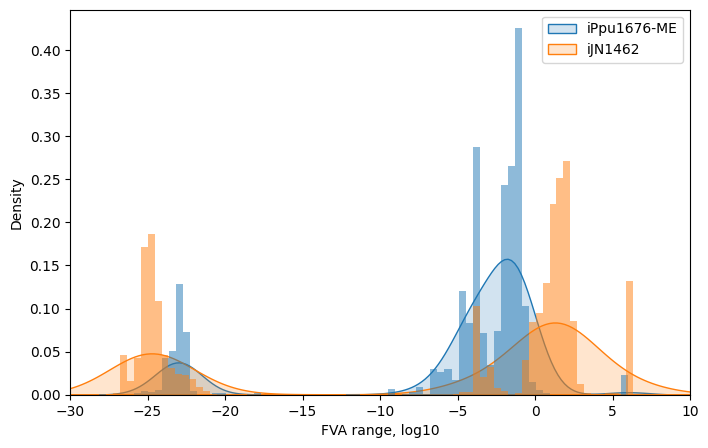

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate example data
data1 = get_deltas(me_model_fva).values
data2 = get_deltas(m_model_fva).values

# Create density plot
plt.figure(figsize=(8, 5))
sns.kdeplot(data1, label='iPpu1676-ME', fill=True, alpha=0.2)
sns.kdeplot(data2, label='iJN1462', fill=True, alpha=0.2)
plt.hist(data1, bins=75, density=True, alpha=0.5)
plt.hist(data2, bins=75, density=True, alpha=0.5)
plt.xlim(-30,10)
# plt.vlines(x=-16,ymin=0.,ymax=0.35,linestyles="--",color="gray")

plt.xlabel("FVA range, log10")
plt.ylabel("Density")
plt.legend()
plt.savefig("./figures/FVA-MvsME.svg",format="SVG")